## Explore xPAL Code

https://github.com/scikit-activeml/scikit-activeml


### Pool Based Active Learning

In [156]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier
from skactiveml.visualization import plot_decision_boundary, plot_utilities
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from Website import Website
from PostgresDatabase import PostgresDatabase
import pycld2 as cld2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [164]:
class Dataset:
    def __init__(self):
        self.websites = []
        self.data = []
        self.target = []

        db = PostgresDatabase()
        db.connect()
        if db.connection:
            db.execute('SELECT * FROM site_data;')
            result = db.cursor.fetchall()
            db.close()

            for row in result:
                w = Website(name=row[1], i_url=row[2], v_url=row[3], text=row[4], category=row[5], tags=row[6])
                self.websites.append(w)
                self.data.append(w.text)
                self.target.append(w.category)

In [165]:
def preprocessing(train_data:np.ndarray, debugging:bool = False) -> tuple[np.ndarray, np.ndarray]:
    # get ENGLISH CZECH SLOVAK data
    lang_array = [None] * len(train_data)
    lang_array = np.array(lang_array)
    # preprocess data with regex, remove numbers and symbols
    for i in range(len(train_data)):
        text = train_data[i]
        text = re.sub(r'[^\w\s]+', ' ', text, flags=re.UNICODE)
        text = re.sub('\d', ' ', text)
        text = re.sub("\s{2,}", ' ', text)
        train_data[i] = text[:3000]

    for i in range(len(train_data)):
        isReliable, textBytesFound, details, vectors = cld2.detect(train_data[i], returnVectors=True)
        if len(vectors) != 0 and isReliable:
            for v in vectors:
                if v[2] != 'Unknown':
                    lang_array[i] = v[2]
                    break
        if lang_array[i] == None:
            lang_array[i] = 'Unknown'    

    # get indicies of english data using numpy
    selected_language_indicies = np.where((lang_array == 'ENGLISH'))# | (lang_array == 'CZECH') | (lang_array == 'SLOVAK'))
    unknown_indicies = np.where(lang_array == 'Unknown')

    if debugging:    
        unk = np.array(train_data)[unknown_indicies]
        for d in unk:
            print(d)
            print(80*"-")
    return selected_language_indicies, lang_array

In [166]:
# Generate data set.
# X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)
train = Dataset()
train_data = train.data
train_target = train.target

selected_language_indicies, lang_array = preprocessing(train_data)

train_data = np.array(train_data)[selected_language_indicies]
train_target = np.array(train_target)[selected_language_indicies]

X = np.array(train_data)
y_true = np.array(train_target)
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

# print("X \n", X[:5])
print("X shape", X.shape)
print("y_true \n", y_true[:5])
print("y", y[:5])
print("y shape", y.shape)

X shape (200,)
y_true 
 ['House And Garden' 'Food And Drink' 'Food And Drink' 'Food And Drink'
 'Car']
y [nan nan nan nan nan]
y shape (200,)


In [167]:
# GaussianProcessClassifier needs initial training data otherwise a warning will
# be raised by SklearnClassifier. Therefore, the first 10 instances are used as
# training data.

vectorizer = TfidfVectorizer(analyzer="word", strip_accents="unicode", max_features=8000)
X = vectorizer.fit_transform(X)
print(X[:1])

le = LabelEncoder()
le.fit(y_true)
y_true = le.transform(y_true)

y[:10] = y_true[:10]
print(y.shape)
print(y_true.shape)

  (0, 2208)	0.2858597239411784
  (0, 3603)	0.32977878989584
  (0, 1435)	0.32977878989584
  (0, 2159)	0.7109395930920324
  (0, 3769)	0.1849047176119955
  (0, 4112)	0.4014364932052239
(200,)
(200,)


In [168]:
# Create classifier and query strategy.
clf = SklearnClassifier(GaussianProcessClassifier(random_state=0),classes=np.unique(y_true), random_state=0)
qs = UncertaintySampling(method='entropy')

ValueError: Samples in `X` must have 2 features.

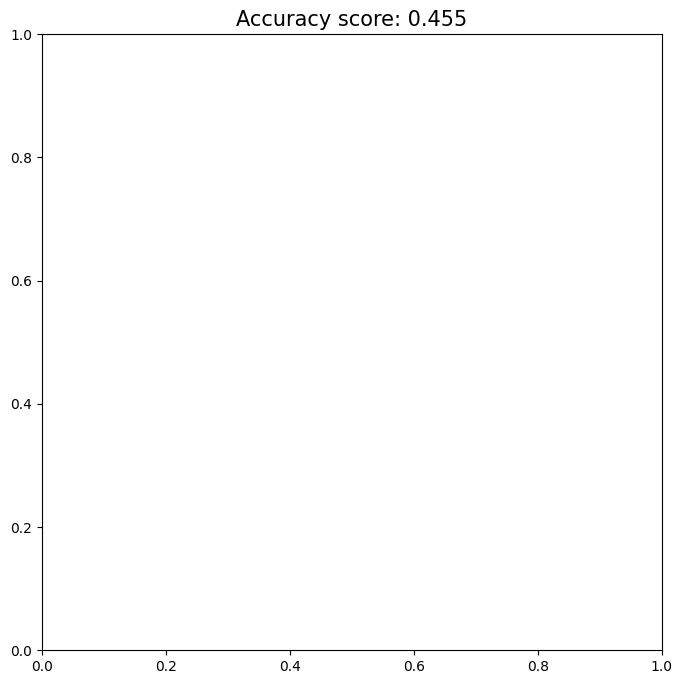

In [169]:
# Execute active learning cycle.
X = X.toarray()

n_cycles = 20
for c in range(n_cycles):
    query_idx = qs.query(X=X, y=y, clf=clf)
    y[query_idx] = y_true[query_idx]

# Fit final classifier.
clf.fit(X, y)

# Visualize resulting classifier and current utilities.
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
unlbld_idx = unlabeled_indices(y)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title(f'Accuracy score: {clf.score(X,y_true)}', fontsize=15)
plot_utilities(qs, X=X, y=y, clf=clf, feature_bound=bound, ax=ax)
plot_decision_boundary(clf, feature_bound=bound, confidence=0.6)
plt.scatter(X[unlbld_idx,0], X[unlbld_idx,1], c='gray')
plt.scatter(X[:,0], X[:,1], c=y, cmap='jet')
plt.show()

### Stream Based Active Learning

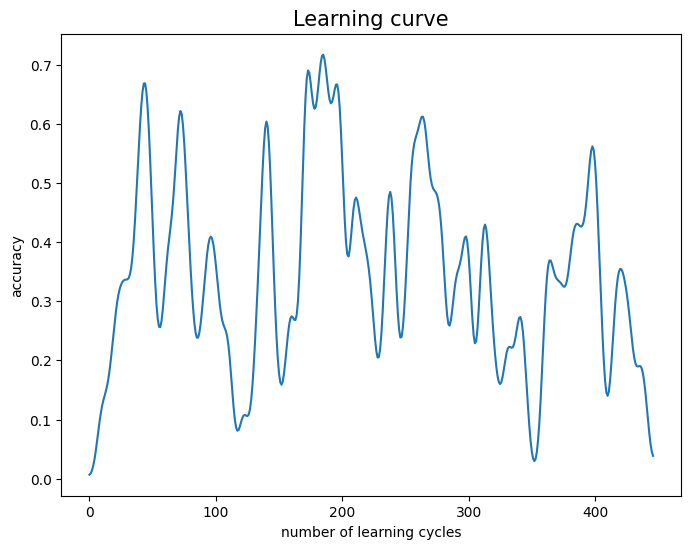

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.datasets import make_blobs
from skactiveml.classifier import ParzenWindowClassifier
from skactiveml.stream import Split
from skactiveml.utils import MISSING_LABEL

# Generate data set.
# X, y_true = make_blobs(n_samples=200, centers=4, random_state=0)

# Create classifier and query strategy.
clf = ParzenWindowClassifier(random_state=0, classes=np.unique(y_true))
qs = Split(random_state=0)

# Initializing the training data as an empty array.
X_train = []
y_train = []

# Initialize the list that stores the result of the classifier's prediction.
correct_classifications = []

# Execute active learning cycle.
for x_t, y_t in zip(X, y_true):
    X_cand = x_t.reshape([1, -1])
    y_cand = y_t
    clf.fit(X_train, y_train)
    correct_classifications.append(clf.predict(X_cand)[0] == y_cand)
    sampled_indices = qs.query(candidates=X_cand, clf=clf)
    qs.update(candidates=X_cand, queried_indices=sampled_indices)
    X_train.append(x_t)
    y_train.append(y_cand if len(sampled_indices) > 0 else MISSING_LABEL)

# Plot the classifier's learning accuracy.
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.set_title(f'Learning curve', fontsize=15)
ax.set_xlabel('number of learning cycles')
ax.set_ylabel('accuracy')
ax.plot(gaussian_filter1d(np.array(correct_classifications, dtype=float), 4))
plt.show()